# Dataset Preparation:

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Labels:

In [2]:
import csv
import os
from pathlib import Path

dataset_path = Path('/content/drive/My Drive/Traffic Signs Dataset')
dataset_train_path = dataset_path / 'Train'
dataset_val_path = dataset_path / 'Val'
dataset_test_path = dataset_path / 'Test'
dataset_labels_path = dataset_path / 'Labels.csv'

In [3]:
from typing import Dict

def load_dataset_classes_to_dict(dataset_labels_path: Path) -> Dict[str, str]:
  dataset_classes = {}
  with open(dataset_labels_path, mode='r') as dataset_labels_file:
          dataset_labels_rows = csv.DictReader(dataset_labels_file)
          for row in dataset_labels_rows:
              class_id = row['ClassId']
              name = row['Name']
              dataset_classes[class_id] = name
  return dataset_classes

dataset_classes = load_dataset_classes_to_dict(dataset_labels_path)
class_names = list(dataset_classes.keys())
dataset_classes

{'0': 'Speed Limit (30km/h)',
 '1': 'Speed Limit (40km/h)',
 '2': 'Speed Limit (50km/h)',
 '3': 'Speed Limit (60km/h)',
 '4': 'speed Limit (80km/h)',
 '5': 'Dont Go Straight',
 '6': 'Dont Go Left',
 '7': 'Dont Go Right',
 '8': 'Go Right',
 '9': 'Keep Right',
 '10': 'Zebra Crossing',
 '11': 'Children Crossing',
 '12': 'Dangerous Curve Right',
 '13': 'Dangerous Curve Left',
 '14': 'No Stopping',
 '15': 'No Entry'}

### Images:

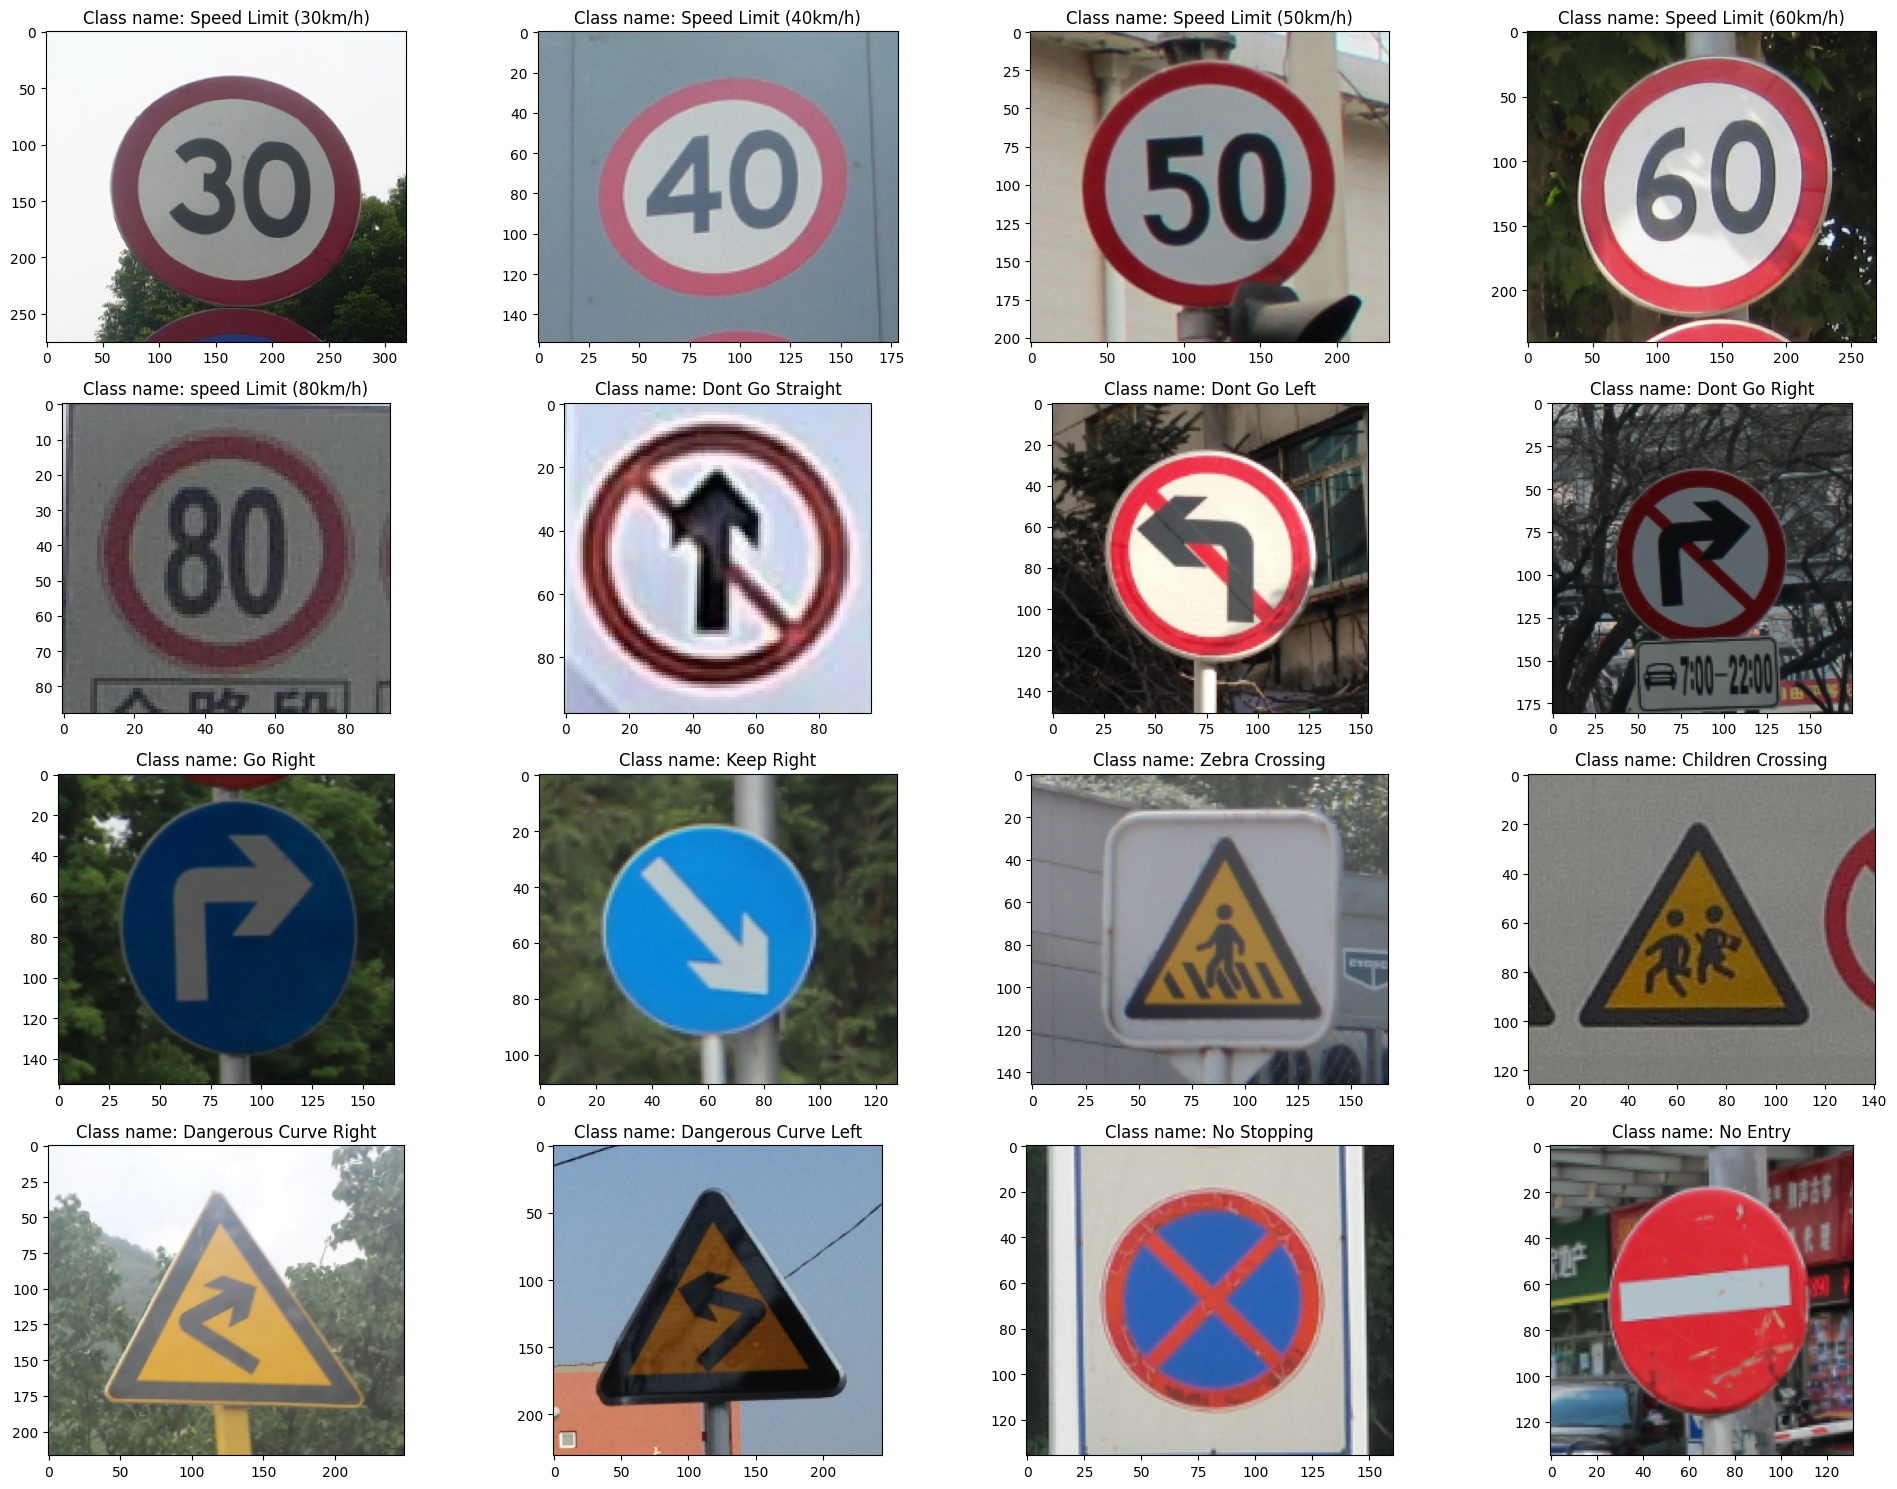

In [4]:
import matplotlib.pyplot as plt
import cv2

def show_dataset_images(dataset_train_path: Path, dataset_classes: Dict[str, str], images_idx: int) -> None:
  classes_number = len(dataset_classes)
  fig, axes = plt.subplots(4, 4, figsize=(20, 15))
  axes = axes.flatten()
  for class_number in range(classes_number):
      class_folder_path = dataset_train_path / str(class_number)
      class_images = os.listdir(class_folder_path)
      image_path = class_folder_path / class_images[images_idx]
      image = cv2.imread(str(image_path))
      image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      ax = axes[class_number]
      ax.imshow(image_rgb)
      ax.set_title(f'Class name: {dataset_classes[str(class_number)]}', fontsize=12)
  plt.tight_layout()
  plt.show()

show_dataset_images(dataset_train_path, dataset_classes, images_idx=10)

<br> <br>
# **TensorFlow - Custom Model:**

### Image Generators:

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_target_size = (64, 64)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=False,
    width_shift_range=0.0,
    height_shift_range=0.0,
)
train_generator = train_datagen.flow_from_directory(
        dataset_train_path,
        target_size=image_target_size,
        batch_size=32,
        class_mode='categorical',
        classes=class_names,
        shuffle=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        dataset_val_path,
        target_size=image_target_size,
        batch_size=16,
        class_mode='categorical',
        classes=class_names,
        shuffle=False
)

Found 1476 images belonging to 16 classes.
Found 400 images belonging to 16 classes.


### Model:

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback
from typing import Tuple, List


class CustomTFModel(tf.keras.Model):
    def __init__(self, conv_filters: List[int]):
        super(CustomTFModel, self).__init__()
        self.conv_layers = []
        for conv_filter in conv_filters:
            self.conv_layers.append(tf.keras.layers.Conv2D(conv_filter, (3, 3), activation='relu'))
            self.conv_layers.append(tf.keras.layers.MaxPooling2D(2, 2))
            self.conv_layers.append(tf.keras.layers.Dropout(0.2))

        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(256, activation='relu')
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.output_layer = tf.keras.layers.Dense(16, activation='softmax')

    def call(self, inputs):
        x = inputs
        for layer in self.conv_layers:
            x = layer(x)

        x = self.flatten(x)
        x = self.dense(x)
        x = self.dropout(x)
        outputs = self.output_layer(x)
        return outputs

custom_tf_model = CustomTFModel(conv_filters=[32, 64, 128])

custom_tf_model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=0.0001),
    metrics=['accuracy']
)

### Callback:

In [7]:
class EarlyStoppingByLossDropCallback(Callback):
    def __init__(self, patience: int):
        super(EarlyStoppingByLossDropCallback, self).__init__()
        self.patience = patience
        self.best_val_loss = float('inf')
        self.num_bad_epochs = 0

    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get('val_loss')
        if current_val_loss is not None:
            if current_val_loss > self.best_val_loss:
                self.num_bad_epochs += 1
                if self.num_bad_epochs == self.patience:
                    print(f"\nTraining stopped as validation loss increased for {self.num_bad_epochs} consecutive epochs.")
                    self.model.stop_training = True
            else:
                self.num_bad_epochs = 0
                self.best_val_loss = current_val_loss

early_stopping_callback = EarlyStoppingByLossDropCallback(patience=3)

### Training:

In [8]:
training_history = custom_tf_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=40,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping_callback]
)

Epoch 1/40
46/46 [==============================] - 480s 10s/step - loss: 2.6793 - accuracy: 0.1517 - val_loss: 2.6574 - val_accuracy: 0.2250
Epoch 2/40
46/46 [==============================] - 10s 220ms/step - loss: 2.3940 - accuracy: 0.2625 - val_loss: 2.3361 - val_accuracy: 0.3350
Epoch 3/40
46/46 [==============================] - 9s 194ms/step - loss: 2.0215 - accuracy: 0.3788 - val_loss: 1.9910 - val_accuracy: 0.4100
Epoch 4/40
46/46 [==============================] - 10s 212ms/step - loss: 1.7037 - accuracy: 0.4501 - val_loss: 1.7469 - val_accuracy: 0.4550
Epoch 5/40
46/46 [==============================] - 10s 217ms/step - loss: 1.4813 - accuracy: 0.5229 - val_loss: 1.5897 - val_accuracy: 0.4100
Epoch 6/40
46/46 [==============================] - 9s 200ms/step - loss: 1.3635 - accuracy: 0.5409 - val_loss: 1.4356 - val_accuracy: 0.5350
Epoch 7/40
46/46 [==============================] - 9s 194ms/step - loss: 1.2381 - accuracy: 0.5914 - val_loss: 1.3342 - val_accuracy: 0.5525
Epo

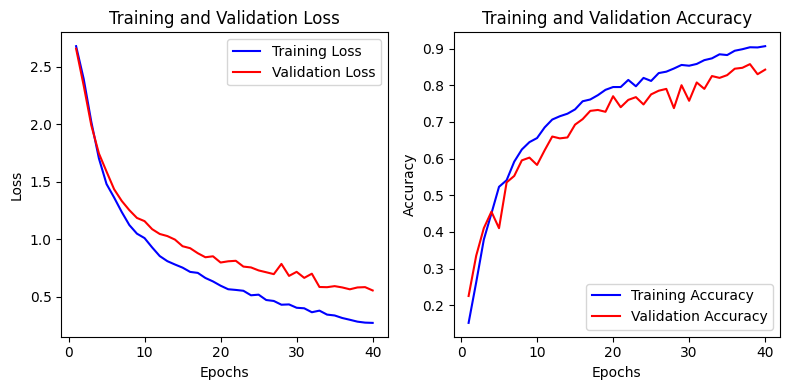

In [9]:
import matplotlib.pyplot as plt

train_loss = training_history.history['loss']
train_acc = training_history.history['accuracy']
val_loss = training_history.history['val_loss']
val_acc = training_history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### Confusion Matrix:

25/25 [==============================] - 2s 63ms/step


<Figure size 1200x1000 with 0 Axes>

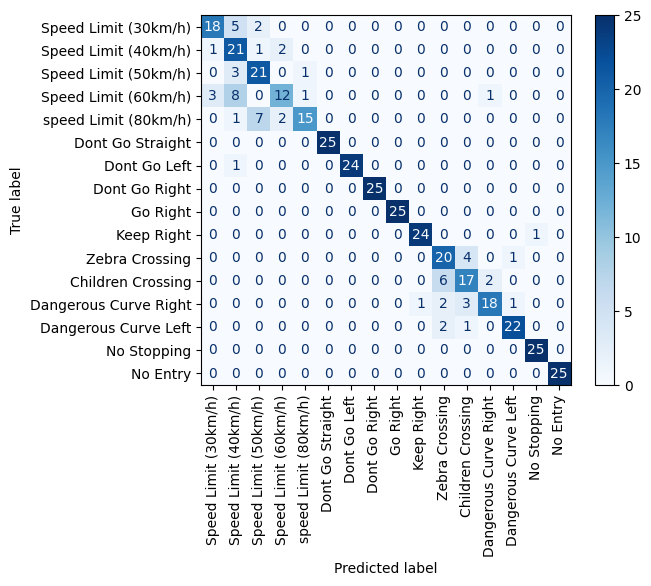

In [54]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model: tf.keras.Model) -> None:
  val_generator.reset()
  predictions = model.predict(val_generator)
  predicted_classes = np.argmax(predictions, axis=1)
  true_classes = val_generator.classes
  class_labels = [dataset_classes[str(i)] for i in range(len(dataset_classes))]

  conf_matrix = confusion_matrix(true_classes, predicted_classes)
  conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)

  plt.figure(figsize=(12, 10))
  conf_disp.plot(cmap=plt.cm.Blues)
  plt.xticks(rotation=90)
  plt.show()

plot_confusion_matrix(custom_tf_model)

### Prediction:

1/1 [==============================] - 0s 46ms/step


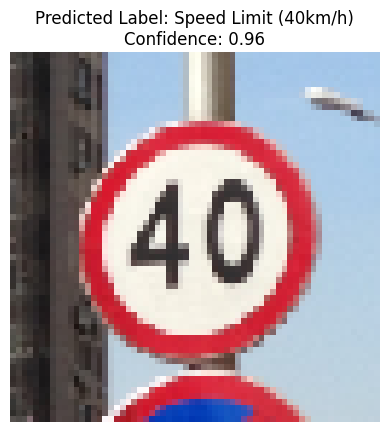

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image


def load_and_preprocess_image(image_path: Path, target_size: Tuple[int, int]) -> np.ndarray:
    loaded_image = image.load_img(image_path, target_size=target_size)
    image_array = image.img_to_array(loaded_image)
    image_expanded = np.expand_dims(image_array, axis=0)
    image_normalized = image_expanded / 255.0
    return image_normalized

def display_image_with_prediction(image: np.ndarray, predicted_label: str, confidence: float) -> None:
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Predicted Label: {predicted_label}\nConfidence: {confidence:.2f}')
    plt.show()

def predict_image(model: tf.keras.Model, image_path: Path, target_size: Tuple[int, int]) -> None:
    image_array = load_and_preprocess_image(image_path, target_size)

    predictions = model.predict(image_array)
    predicted_index = np.argmax(predictions[0])
    predicted_label = dataset_classes[str(predicted_index)]
    confidence = np.max(predictions[0])

    display_image_with_prediction(image_array[0], predicted_label, confidence)


image_path = dataset_path / "Test"/ "003_0001_j.png"
predict_image(custom_tf_model, image_path, image_target_size)

# **TensorFlow - Transfer Learning (VGG 16):**

## Model:

In [51]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback
from typing import List


class VGGBasedTFModel(tf.keras.Model):
    def __init__(self):
        super(VGGBasedTFModel, self).__init__()
        self.base_model = VGG16(weights='imagenet', include_top=False)

        for layer in self.base_model.layers[:-3]:
            layer.trainable = False

        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(256, activation='relu')
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.output_layer = tf.keras.layers.Dense(16, activation='softmax')

    def call(self, inputs):
        x = self.base_model(inputs)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.dropout(x)
        outputs = self.output_layer(x)
        return outputs


vgg_based_tf_model = VGGBasedTFModel()

vgg_based_tf_model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=0.0001),
    metrics=['accuracy']
)

## Training:

In [52]:
early_stopping_callback = EarlyStoppingByLossDropCallback(patience=1)

training_history = vgg_based_tf_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping_callback]
)

Epoch 1/20
46/46 [==============================] - 14s 208ms/step - loss: 1.2970 - accuracy: 0.5845 - val_loss: 0.9454 - val_accuracy: 0.6550
Epoch 2/20
46/46 [==============================] - 10s 222ms/step - loss: 0.6619 - accuracy: 0.7670 - val_loss: 0.7202 - val_accuracy: 0.7625
Epoch 3/20
46/46 [==============================] - 10s 220ms/step - loss: 0.4383 - accuracy: 0.8511 - val_loss: 0.7103 - val_accuracy: 0.7700
Epoch 4/20
46/46 [==============================] - 9s 202ms/step - loss: 0.3459 - accuracy: 0.8830 - val_loss: 0.5829 - val_accuracy: 0.8250
Epoch 5/20
46/46 [==============================] - ETA: 0s - loss: 0.2720 - accuracy: 0.9065
Training stopped as validation loss increased for 1 consecutive epochs.
46/46 [==============================] - 10s 222ms/step - loss: 0.2720 - accuracy: 0.9065 - val_loss: 0.6075 - val_accuracy: 0.8175


## Confusion Matrix:

25/25 [==============================] - 2s 65ms/step


<Figure size 1200x1000 with 0 Axes>

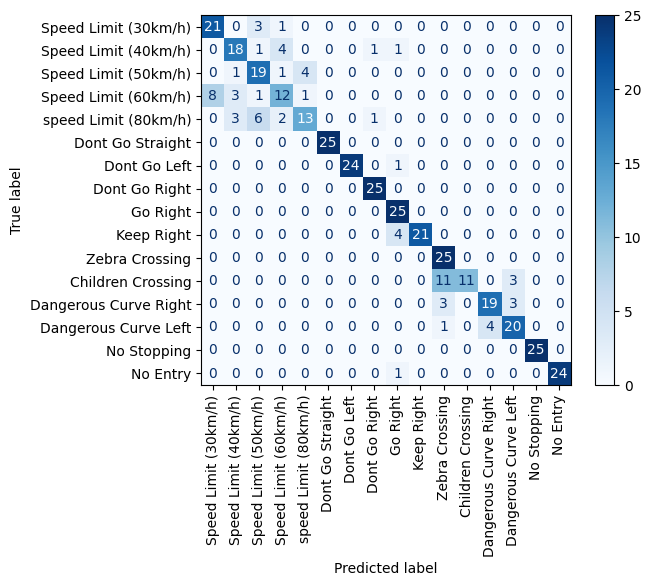

In [55]:
plot_confusion_matrix(vgg_based_tf_model)

## Prediction:

1/1 [==============================] - 0s 27ms/step


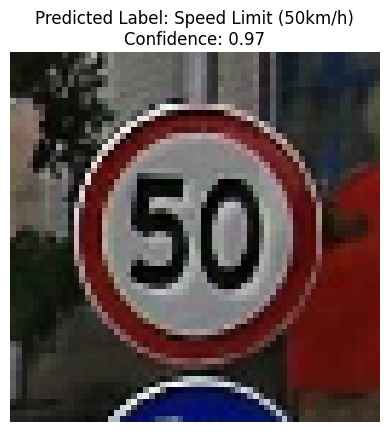

In [63]:
image_path = dataset_path / "Test"/ "004_0001_j.png"
predict_image(vgg_based_tf_model, image_path, image_target_size)

# **PyTorch Lightning - Custom Model**:

In [ ]:
!pip install pytorch_lightning

### Dataloaders:

In [64]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

class CustomImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        classes = [d for d in sorted(os.listdir(directory)) if os.path.isdir(os.path.join(directory, d))]
        classes.sort(key=lambda x: int(x))
        class_to_idx = {class_names[int(cls)]: int(cls) for cls in classes}
        return class_names, class_to_idx

image_target_size = (64, 64)
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=[0.8, 1.2]),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, shear=0.2, scale=(0.8, 1.2)),
    transforms.Resize(image_target_size),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(image_target_size),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = CustomImageFolder(root=dataset_train_path, transform=transform_train)
val_dataset = CustomImageFolder(root=dataset_val_path, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

### Model:

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torchmetrics


class CustomPLModel(pl.LightningModule):
    def __init__(self, conv_filters):
        super(CustomPLModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=conv_filters[0], kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2),
            nn.Conv2d(in_channels=conv_filters[0], out_channels=conv_filters[1], kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2),
            nn.Conv2d(in_channels=conv_filters[1], out_channels=conv_filters[2], kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2)
        )

        self.flatten_size = conv_filters[2] * 8 * 8
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(in_features=self.flatten_size, out_features=256)
        self.dropout = nn.Dropout(0.2)
        self.output_layer = nn.Linear(in_features=256, out_features=16)

        self.train_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=16)
        self.val_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=16)
        self.step_metrics = {"train_loss": [], "train_accuracy": [], "val_loss": [], "val_accuracy": []}
        self.metrics = {"train_loss": [], "train_accuracy": [], "val_loss": [], "val_accuracy": []}

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = F.relu(self.dense(x))
        x = self.dropout(x)
        x = self.output_layer(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.train_accuracy(y_hat, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_accuracy", acc, on_step=False, on_epoch=True, prog_bar=True)
        self.step_metrics["train_loss"].append(loss.item())
        self.step_metrics["train_accuracy"].append(acc)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.val_accuracy(y_hat, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_accuracy", acc, on_step=False, on_epoch=True, prog_bar=True)
        self.step_metrics["val_loss"].append(loss.item())
        self.step_metrics["val_accuracy"].append(acc)
        return loss

    def on_validation_epoch_end(self):
        for key, values in self.step_metrics.items():
            self.metrics[key].append(torch.mean(torch.tensor(values)).item())
            self.step_metrics[key] = []

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

custom_pl_model = CustomPLModel(conv_filters=[32, 64, 128])

early_stopping_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

### Training:

In [ ]:
trainer = pl.Trainer(max_epochs=40, callbacks=[early_stopping_callback], log_every_n_steps=1)
trainer.fit(custom_pl_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

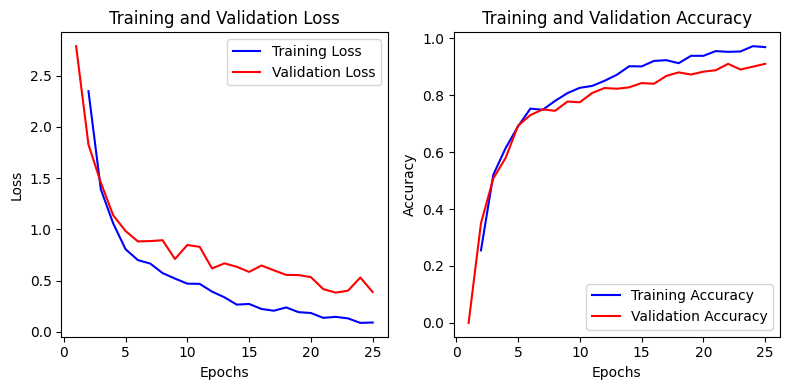

In [67]:
import matplotlib.pyplot as plt

train_loss = custom_pl_model.metrics['train_loss']
train_acc = custom_pl_model.metrics['train_accuracy']
val_loss = custom_pl_model.metrics['val_loss']
val_acc = custom_pl_model.metrics['val_accuracy']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Confusion Matrix:

<Figure size 1200x1000 with 0 Axes>

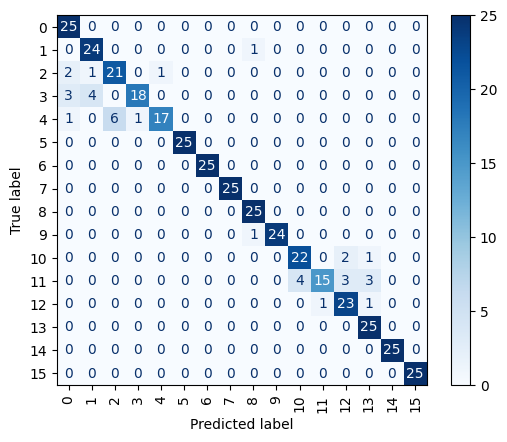

In [68]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model: pl.LightningModule, val_loader: DataLoader, class_labels: list) -> None:
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    conf_matrix = confusion_matrix(all_labels, all_preds)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)

    plt.figure(figsize=(12, 10))
    conf_disp.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=90)
    plt.show()

plot_confusion_matrix(custom_pl_model, val_loader, class_names)

### Prediction:

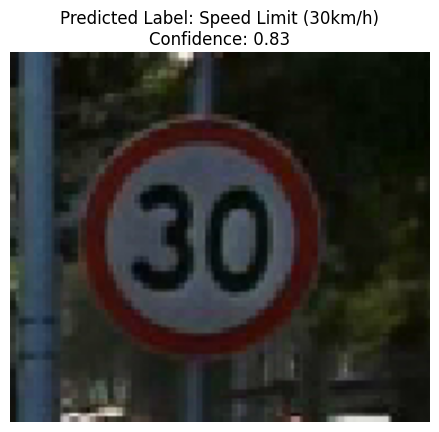

In [71]:
from PIL import Image

def load_and_preprocess_image(image_path: Path, transform: transforms.Compose) -> torch.Tensor:
    image = Image.open(image_path).convert("RGB")
    image_transformed = transform(image).unsqueeze(0)
    return image_transformed

def display_image_with_prediction(image: np.ndarray, predicted_label: str, confidence: float) -> None:
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Predicted Label: {predicted_label}\nConfidence: {confidence:.2f}')
    plt.show()

def predict_image(model: torch.nn.Module, image_path: Path, transform: transforms.Compose, class_labels: list) -> None:
    image_tensor = load_and_preprocess_image(image_path, transform)

    model.eval()
    with torch.no_grad():
        predictions = model(image_tensor)

    predictions = torch.nn.functional.softmax(predictions[0], dim=0)
    predicted_index = torch.argmax(predictions).item()
    predicted_label = class_labels[str(predicted_index)]
    confidence = predictions[predicted_index].item()

    image = Image.open(image_path).convert("RGB")
    image_array = np.array(image)

    display_image_with_prediction(image_array, predicted_label, confidence)


image_path = dataset_path / "Test"/ "002_0028.png"
predict_image(custom_pl_model, image_path, transform_val, dataset_classes)

# **PyTorch Lightning - Transfer Learning (VGG 16)**:

### Model:

In [ ]:
from torchvision import models

class VGGBasedPLModel(pl.LightningModule):
    def __init__(self):
        super(VGGBasedPLModel, self).__init__()
        vgg16 = models.vgg16(pretrained=True)

        for param in vgg16.parameters():
            param.requires_grad = False
        for param in vgg16.features[24:].parameters():
            param.requires_grad = True
        self.features = vgg16.features

        self.flatten = nn.Flatten()
        self.dense = nn.Linear(512 * 2 * 2, 256)
        self.dropout = nn.Dropout(0.2)
        self.output_layer = nn.Linear(256, out_features=16)

        self.train_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=16)
        self.val_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=16)
        self.step_metrics = {"train_loss": [], "train_accuracy": [], "val_loss": [], "val_accuracy": []}
        self.metrics = {"train_loss": [], "train_accuracy": [], "val_loss": [], "val_accuracy": []}

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = F.relu(self.dense(x))
        x = self.dropout(x)
        x = self.output_layer(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.train_accuracy(y_hat, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_accuracy", acc, on_step=False, on_epoch=True, prog_bar=True)
        self.step_metrics["train_loss"].append(loss.item())
        self.step_metrics["train_accuracy"].append(acc)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.val_accuracy(y_hat, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_accuracy", acc, on_step=False, on_epoch=True, prog_bar=True)
        self.step_metrics["val_loss"].append(loss.item())
        self.step_metrics["val_accuracy"].append(acc)
        return loss

    def on_validation_epoch_end(self):
        for key, values in self.step_metrics.items():
            self.metrics[key].append(torch.mean(torch.tensor(values)).item())
            self.step_metrics[key] = []

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

early_stopping_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=4, mode='min')
vgg_based_pl_model = VGGBasedPLModel()

### Training:

In [ ]:
trainer = pl.Trainer(max_epochs=40, callbacks=[early_stopping_callback], log_every_n_steps=1)
trainer.fit(vgg_based_pl_model, train_dataloaders=train_loader, val_dataloaders=val_loader,)

### Confusion Matrix:

<Figure size 1200x1000 with 0 Axes>

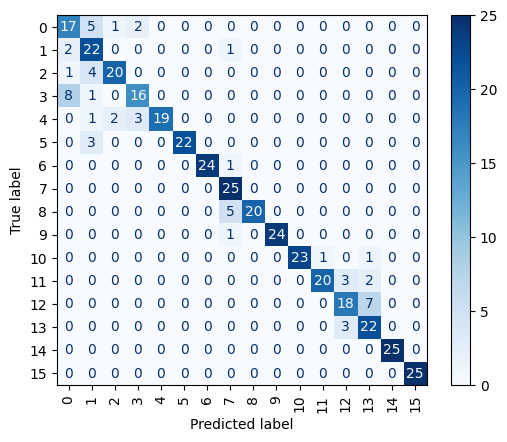

In [86]:
plot_confusion_matrix(vgg_based_pl_model, val_loader, class_names)

### Prediction:

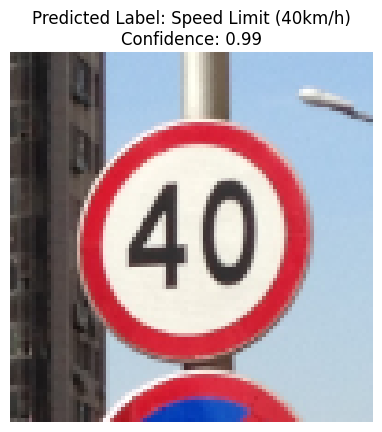

In [87]:
image_path = dataset_path / "Test"/ "003_0001_j.png"
predict_image(vgg_based_pl_model, image_path, transform_val, dataset_classes)